# SYSTEM RUN

In [62]:
import hoomd
import hoomd.hpmc
import ex_render
import math
import random
from shapely.geometry import Polygon
hoomd.context.initialize("--mode=cpu");

In [63]:
def polygon(n, a, alpha0, p0):
    l = []
    p = [0, a]
    p = [p[0]*math.cos(alpha0) - p[1]*math.sin(alpha0), p[1]*math.cos(alpha0) + p[0]*math.sin(alpha0)]
    alpha = 2*math.pi/n
    for i in range(n):
        p = [p[0]*math.cos(alpha) - p[1]*math.sin(alpha), p[1]*math.cos(alpha) + p[0]*math.sin(alpha)]
        l.append([p[0]+p0[0], p[1]+p0[1]])
    return l

In [80]:
count_poly = 15
rad_poly = 0.05
rad_hex = 0.5
n_vertex = 21
coords = []
vertex = []
types = []
diameters=[]

#Hexagon
p_hex = [0,0,0]
coords.append(p_hex)
vertex.append(polygon(6, rad_hex, math.pi/6, p_hex[0:2]))
types.append('A')
diameters.append(2*rad_hex)
hex_coords = []
for v in vertex[0]:
    hex_coords.append((p_hex[0]+v[0], p_hex[1]+v[1]))
hex_obj = Polygon(hex_coords)

#Small-polygons (disks) lattice constructor
list_obj = [hex_obj]
k = 0
while k < count_poly:
    x = random.uniform(-0.5 + rad_poly, 0.5 - rad_poly)
    y = random.uniform(-0.5 + rad_poly, 0.5 - rad_poly)
    poly_coords = polygon(n_vertex, rad_poly, 0, [x, y])
    poly_obj = Polygon(poly_coords)
    flag = False
    for obj in list_obj:
        if obj.intersects(poly_obj):
            flag = True
            break
    if flag == False:
        list_obj.append(poly_obj)
        coords.append([x, y, 0])
        vertex.append(polygon(n_vertex, rad_poly, 0, [0, 0]))
        diameters.append(2*rad_poly)
        types.append('B')
        k += 1
        print k
#for i in range(count_box):
#    for j in range(count_box):
#        x, y = -0.5 + dx/2 + i*dx, -0.5 + dy/2 + j*dy
#        poly_coords = polygon(n_vertex, rad_poly, 0, [x, y])
#        poly_obj = Polygon(poly_coords)
#        #Adding disk to lattice if the one dont intersecting hexagone
#        if hex_obj.intersects(poly_obj) == False:
#            vertex.append(polygon(n_vertex, rad_poly, 0, [0, 0]))
#            types.append('B')
#            diameters.append(2*rad_poly)
#            count_poly += 1
sqr_hex = 6*rad_hex**2*math.cos(math.pi/6)*math.sin(math.pi/6)
sqr_poly = count_poly*n_vertex*rad_poly**2*math.cos(math.pi/n_vertex)*math.sin(math.pi/n_vertex)
etta = (sqr_hex + sqr_poly)
print etta

1
2
3
4
5
6
7
8
9
10
11
12
13
14


KeyboardInterrupt: 

In [65]:
uc = hoomd.lattice.unitcell(N=count_poly + 1,
                            a1=[1.0, 0, 0],
                            a2=[0, 1.0, 0],
                            a3=[0, 0, 1.0],
                            dimensions=2,
                            position=coords,
                            diameter=diameters,
                            type_name=types);

In [66]:
system = hoomd.init.create_lattice(unitcell=uc, n=[1, 1]);

notice(2): Group "all" created containing 11 particles


In [67]:
mc = hoomd.hpmc.integrate.convex_polygon(d=0.01, a=0.01, seed=189);
square_vertsA = vertex[0];
mc.shape_param.set('A', vertices=square_vertsA);
square_vertsB = vertex[1];
mc.shape_param.set('B', vertices=square_vertsB);

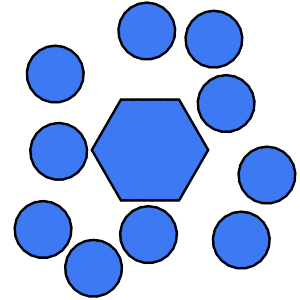

In [68]:
ex_render.render_2polygons_frame(system.take_snapshot(all=True), square_vertsA, square_vertsB)

In [26]:
d = hoomd.dump.gsd("trajectory.gsd", period=10, group=hoomd.group.all(), overwrite=True);

In [27]:
hoomd.run(10000);

** starting run **
Time 00:00:15 | Step 274 / 10000 | TPS 27.3647 | ETA 00:05:55
Time 00:00:25 | Step 531 / 10000 | TPS 25.6744 | ETA 00:06:08
Time 00:00:35 | Step 803 / 10000 | TPS 27.1495 | ETA 00:05:38
Time 00:00:45 | Step 1070 / 10000 | TPS 26.6438 | ETA 00:05:35
Time 00:00:55 | Step 1337 / 10000 | TPS 26.6263 | ETA 00:05:25
Time 00:01:05 | Step 1614 / 10000 | TPS 27.6938 | ETA 00:05:02
Time 00:01:15 | Step 1890 / 10000 | TPS 27.5307 | ETA 00:04:54
Time 00:01:25 | Step 2157 / 10000 | TPS 26.6797 | ETA 00:04:53
Time 00:01:35 | Step 2423 / 10000 | TPS 26.5028 | ETA 00:04:45
Time 00:01:45 | Step 2688 / 10000 | TPS 26.4062 | ETA 00:04:36
Time 00:01:55 | Step 2944 / 10000 | TPS 25.5601 | ETA 00:04:36
Time 00:02:05 | Step 3195 / 10000 | TPS 25.0892 | ETA 00:04:31
Time 00:02:15 | Step 3456 / 10000 | TPS 26.0753 | ETA 00:04:10
Time 00:02:25 | Step 3721 / 10000 | TPS 26.4733 | ETA 00:03:57
Time 00:02:35 | Step 3982 / 10000 | TPS 26.0341 | ETA 00:03:51
Time 00:02:45 | Step 4209 / 10000 | TPS

In [28]:
tr = ex_render.get_trajectory("trajectory.gsd")

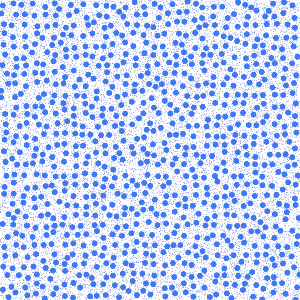

In [29]:
ex_render.render_2polygons_frame(tr[-1], square_vertsA, square_vertsB)

# COMPUTE 1D RDF

In [30]:
from freud import parallel, box, density
parallel.setNumThreads(4)
from bokeh.io import output_notebook
output_notebook()
from bokeh.plotting import figure, output_file, show
from bokeh.layouts import gridplot
import numpy as np

def default_bokeh(p):
    p.title.text_font_size = "18pt"
    p.title.align = "center"

    p.xaxis.axis_label_text_font_size = "14pt"
    p.yaxis.axis_label_text_font_size = "14pt"

    p.xaxis.major_tick_in = 10
    p.xaxis.major_tick_out = 0
    p.xaxis.minor_tick_in = 5
    p.xaxis.minor_tick_out = 0

    p.yaxis.major_tick_in = 10
    p.yaxis.major_tick_out = 0
    p.yaxis.minor_tick_in = 5
    p.yaxis.minor_tick_out = 0

    p.xaxis.major_label_text_font_size = "12pt"
    p.yaxis.major_label_text_font_size = "12pt"

Loading BokehJS ...

In [31]:
p_index = 0
tid = tr[0].particles.typeid == p_index
n_par = len(tr[0].particles.position[tid, 0])
p = np.zeros((n_par, 3), dtype=np.float32)
rdf = density.RDF(rmax=system.box.Lx/2, dr=0.1)
# compute the rdf for for all frames except the first (your syntax will vary based on your reader)
frame_begin = 100
frame_end = 1000
frame_period = 100
# compute the rdf for for first frame
fbox = box.Box(Lx=system.box.Lx, Ly=system.box.Ly, is2D=True)
rdf.compute(fbox, p, p)
p[:, :] = tr[frame_begin].particles.position[tid, 0:3]
p[:, 2] = 0
for i in range(frame_begin, frame_end):
    # read box, position data
    if i % frame_period == 0:
        print "Frame #", i, " process"
    p[:, :] = tr[i].particles.position[tid, 0:3]
    p[:, 2] = 0
    # create the freud box object
    fbox = box.Box(Lx=system.box.Lx, Ly=system.box.Ly, is2D=True)
    # accumulate
    rdf.accumulate(fbox, p, p)

Frame # 100  process
Frame # 200  process
Frame # 300  process
Frame # 400  process
Frame # 500  process
Frame # 600  process
Frame # 700  process
Frame # 800  process
Frame # 900  process


In [32]:
# get the center of the histogram bins
r = rdf.getR()
# get the value of the histogram bins
y = rdf.getRDF()
# create bokeh plot
p = figure(title="RDF", x_axis_label='r', y_axis_label='g(r)')
p.line(r, y, legend="g(r)", line_width=2)
default_bokeh(p)
show(p)

# COMPUTE 2D RDF

In [38]:
import numpy, math, random
import  matplotlib.pyplot as plt

Sigma # 0 : Frame # 100  process
Sigma # 0 : Frame # 102  process
Sigma # 0 : Frame # 104  process
Sigma # 0 : Frame # 106  process
Sigma # 0 : Frame # 108  process
Sigma # 1 : Frame # 100  process
Sigma # 1 : Frame # 102  process
Sigma # 1 : Frame # 104  process
Sigma # 1 : Frame # 106  process
Sigma # 1 : Frame # 108  process
Sigma # 2 : Frame # 100  process
Sigma # 2 : Frame # 102  process
Sigma # 2 : Frame # 104  process
Sigma # 2 : Frame # 106  process
Sigma # 2 : Frame # 108  process
Sigma # 3 : Frame # 100  process
Sigma # 3 : Frame # 102  process
Sigma # 3 : Frame # 104  process
Sigma # 3 : Frame # 106  process
Sigma # 3 : Frame # 108  process


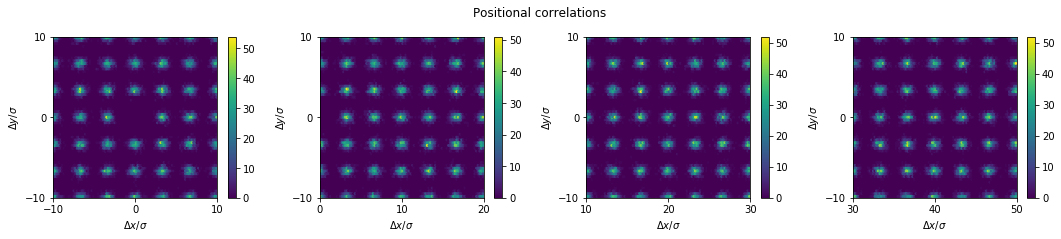

In [39]:
p_index = 0
tid = tr[0].particles.typeid == p_index
N = len(tr[0].particles.position[tid, 0])
p = np.zeros((n_par, 3), dtype=np.float32)
sigma = 0.01
n_sigma = 10
delta = n_sigma*sigma
x_dist = [0*sigma, 10*sigma, 20*sigma, 40*sigma]
x_draw = [[], [], [], []]
y_draw = [[], [], [], []]
M = 100
frame_begin = 100
frame_end = 110
frame_period = 2
for isg in xrange(4):
    for ifr in range(frame_begin, frame_end):
        if ifr % frame_period == 0:
            print "Sigma #", isg, ": Frame #", ifr, " process"
        p[:, :] = tr[ifr].particles.position[tid, 0:3]
        p[:, 2] = 0
        p[:, 0] /= system.box.Lx
        p[:, 1] /= system.box.Ly
        for k in xrange(M*N):
            i = numpy.random.randint(0,N)
            j = numpy.random.randint(0,N)
            yy=(p[j,1]-p[i,1])%1.0
            if yy > 0.5: yy-=1.0
            if abs(yy) < delta:
                xx=(p[j,0]-p[i,0])%1.0
                if xx > 0.5: xx-=1.0
                if abs(xx-x_dist[isg]) < delta and i!=j:
                    x_draw[isg].append(xx/sigma)
                    y_draw[isg].append(yy/sigma)

plt.figure(figsize=(18,3.2))
plt.suptitle('Positional correlations')
plt.subplots_adjust(wspace=.3,bottom=0.15,top=0.85)
for k in xrange(4):
    plt.subplot(1,4,k+1)
    ymin=-n_sigma
    ymax=n_sigma
    xmin=x_dist[k]/sigma - n_sigma
    xmax=x_dist[k]/sigma + n_sigma
    plt.hexbin(x_draw[k],y_draw[k], gridsize=100)
    plt.axis([xmin,xmax,ymin,ymax])
    plt.xlabel("$\Delta x/\sigma$")
    plt.ylabel("$\Delta y/\sigma$",x=30.)
    plt.yticks([-n_sigma,0,n_sigma])
    plt.xticks([xmin,xmin+n_sigma,xmax])
    cb = plt.colorbar()
plt.show()